# Import modules

In [1]:
import pickle
import re
import shap
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.plotting import figure, output_notebook, show

# enable output to display directly in the notebook
output_notebook()

import pandas as pd
import numpy as np


C:\Users\utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BokehJS ...

Importer pipeline,
 récupérer modèle,
  isoler
   exporter 
   ré importer seul
   => feature_importance 
   => shap values locale 
   => recuperer avec fastapi et renvoyer graph

In [13]:
#isoler et enregistrer model
pipeline = open("pipel_4.pkl", "rb")
pipeline = pickle.load(pipeline)
pipeline['rfe'].estimator_


RidgeClassifierCV(alphas=(500, 600), class_weight='balanced', cv=3,
                  scoring='recall')

#export modele
pickle_out = open("model.pkl", "wb")  # ada et lgbm
pickle.dump(model['rfe'].estimator_, pickle_out)
pickle_out.close()

In [14]:
#import model 
model = open("model.pkl","rb")
model = pickle.load(model)
model

RidgeClassifierCV(alphas=(500, 600), class_weight='balanced', cv=3,
                  scoring='recall')

Import jeu de données de issu du train

In [20]:
echantillon_0 = pd.read_csv("../../datasets/application_train.csv")
echantillon = echantillon_0.sample(150, random_state=42).copy()
nettoyage(echantillon)


NameError: name 'nettoyage' is not defined

In [126]:
#vérife répartition target
echantillon['TARGET'].value_counts(dropna=False)

0    132
1     18
Name: TARGET, dtype: int64

In [ ]:
fruits = ['Apples', 'Pears', 'Nectarines', 'Plums', 'Grapes', 'Strawberries']
years = ['2015', '2016', '2017']

data = {'fruits': fruits,
        '2015': [2, 1, 4, 3, 2, 4],
        '2016': [5, 3, 3, 2, 4, 6],
        '2017': [3, 2, 4, 4, 5, 3]}

# this creates [ ("Apples", "2015"), ("Apples", "2016"), ("Apples", "2017"), ("Pears", "2015), ... ]
x = [(fruit, year) for fruit in fruits for year in years]
counts = sum(zip(data['2015'], data['2016'],
             data['2017']), ())  # like an hstack

source = ColumnDataSource(data=dict(x=x, counts=counts))

p = figure(x_range=FactorRange(*x), height=250, title="Fruit counts by year",
           toolbar_location=None, tools="")

p.vbar(x='x', top='counts', width=0.9, source=source)

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None
show(p)


Lime et shap

In [144]:
pickle_in = open("pipel_4.pkl","rb") #notre classifier_test importé v2 avec model pipel_4 plus de parametre
classifier_test=pickle.load(pickle_in) #chargé dans une variable

In [229]:
data_classifier_transfo.shape, len(cols)

((131,), 131)

Transformation données : categ +scaler version avec rfe 

In [259]:
#data_classifier_transfo = classifier_test.steps[0][1].transform(
#    pd.DataFrame(echantillon.iloc[0,:]).transpose())[0][classifier_test.steps[1][1].get_support()]

cols=[re.sub('one-hot-encoder__|remainder__','',col_names) for col_names in classifier_test.steps[0][1].get_feature_names_out()[classifier_test['rfe'].get_support()]]

# transformation + sélection  des variables considérées comme intéressantes par rfe
X_pipe_res = classifier_test.steps[0][1].transform(echantillon.iloc[:15,:])[:,classifier_test.steps[1][1].get_support()] #one hot + scaler 
X_pipe_res.shape, cols[:5]

((15, 131),
 ['NAME_CONTRACT_TYPE_Cash loans',
  'NAME_CONTRACT_TYPE_Revolving loans',
  'CODE_GENDER_F',
  'CODE_GENDER_M',
  'FLAG_OWN_CAR_N'])

In [257]:
#dataframe avec x transformé et colonnes sélectionnées
explainer_X_ = pd.DataFrame(data=X_pipe_res,columns=cols)
explainer_X_.head()

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,NAME_TYPE_SUITE_Family,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Children,...,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,FLAG_DOCUMENT_20,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT
0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,-0.309925,-0.298246,-0.059564,-0.054351,-0.034976,-0.100113,-0.090925,-0.022196,0.898768,-0.285612
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.309925,-0.298246,-0.059564,-0.054351,-0.034976,-0.100113,-0.090925,-0.022196,0.898768,-0.285612
2,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,-0.309925,-0.298246,-0.059564,-0.054351,-0.034976,-0.100113,-0.090925,-0.022196,0.898768,-0.285612
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.309925,-0.298246,-0.059564,-0.054351,-0.034976,-0.100113,-0.090925,-0.022196,-0.268657,-0.285612
4,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.309925,-0.298246,-0.059564,-0.054351,-0.034976,-0.100113,-0.090925,-0.022196,-0.268657,-0.285612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-0.309925,-0.298246,-0.059564,-0.054351,-0.034976,-0.100113,-0.090925,-0.022196,-0.268657,0.955287
146,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.309925,-0.298246,-0.059564,-0.054351,-0.034976,-0.100113,-0.090925,-0.022196,-0.268657,-0.285612
147,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.309925,-0.298246,-0.059564,-0.054351,-0.034976,-0.100113,-0.090925,-0.022196,-0.268657,3.437086
148,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.309925,3.352934,-0.059564,-0.054351,-0.034976,-0.100113,-0.090925,-0.022196,-0.268657,-0.285612


In [266]:
shap_X_= classifier_test.steps[0][1].transform(echantillon.iloc[15:, :])[:, classifier_test.steps[1][1].get_support()]
shap_X_ = pd.DataFrame(data=shap_X_,columns=cols)
shap_X_.shape

(135, 131)

In [272]:
classifier_test['rfe'].estimator_.predict(shap_X_)

X has feature names, but RidgeClassifierCV was fitted without feature names


array([1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0], dtype=int64)

In [273]:
# get shap values
explainer = shap.Explainer(classifier_test['rfe'].estimator_.predict,X_pipe_res)
shap_values = explainer(shap_X_)
shap_values


In [ ]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])


Difficultés : 

pipeline :
1) estimator qu'il faut sortir d'abord
2) Transformé  les données avec la pipeline pour l'entrée le predict et l'explainer
 a) one hot encoder et normalisation
 b) RFE sélection des colonnes
 c) conversion en dataframe  de a pour avoir colonne de b



Comment j'ai fait ? 
qu'est ce qui est attendu => qu'est ce que je donne au modèle 
quelles sont les erreurs, que veulent elles dire ? comment le vérifier ? exemple ou tout fonctionne

isfinite = > valeurs catégorielles à enlever donc transformation à réaliser
shape de la donnée différente => revoir la pipeline

Version locale

In [ ]:
# np.argsort(abs(shap_values[0].values) => garde l'index des  valeurs avant le tri
# np.reshape met sous format 1 ligne et n variables au lieu de n_observation et 1 variable
# [::-1]  # val de shap dans l'ordre croissant / décroissant avec [::-1]
ind_val_tri = np.argsort(abs(shap_values[0].values))
# 1,131 # valeurs une fois triée en utilisant index argsort
val_i_n = shap_values[0].values[ind_val_tri]

df_shap_val = pd.DataFrame(dict(variables=[cols[ind_col] for ind_col in np.argsort(abs(shap_values[0].values))],
                           valeurs=val_i_n))
df_shap_val

In [ ]:

data = dict(y=df_shap_val[df_shap_val['valeurs'] != 0]['variables'],
            x=df_shap_val[df_shap_val['valeurs']!=0]['valeurs'])
data


In [ ]:
# feature importance locale shap_value pour une prédiction
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, CDSView, BooleanFilter
from bokeh.plotting import figure
from bokeh.sampledata.sprint import sprint

TOOLTIPS = [
    ("index", "$index"),
    ("Importance de la variable", "@x"),  # v3
    ("Nom de la variable", "@y")]

source = ColumnDataSource(data)
p = figure(y_range=source.data['y'],
           x_range=(min((df_shap_val_test[0])) -
                    0.05, max(df_shap_val_test[0])+0.05),
           width=600, height=400, toolbar_location=None,
           title="Importance des variables pour la prédiction",
           tooltips=TOOLTIPS)

p.hbar(y='y', right="x", left=0, height=0.4, source=source)

p.ygrid.grid_line_color = None
p.xaxis.axis_label = "Time (seconds)"
p.outline_line_color = None
show(p)


Shap global

In [ ]:
shap.summary_plot(shap_values)

Shap global sans plot

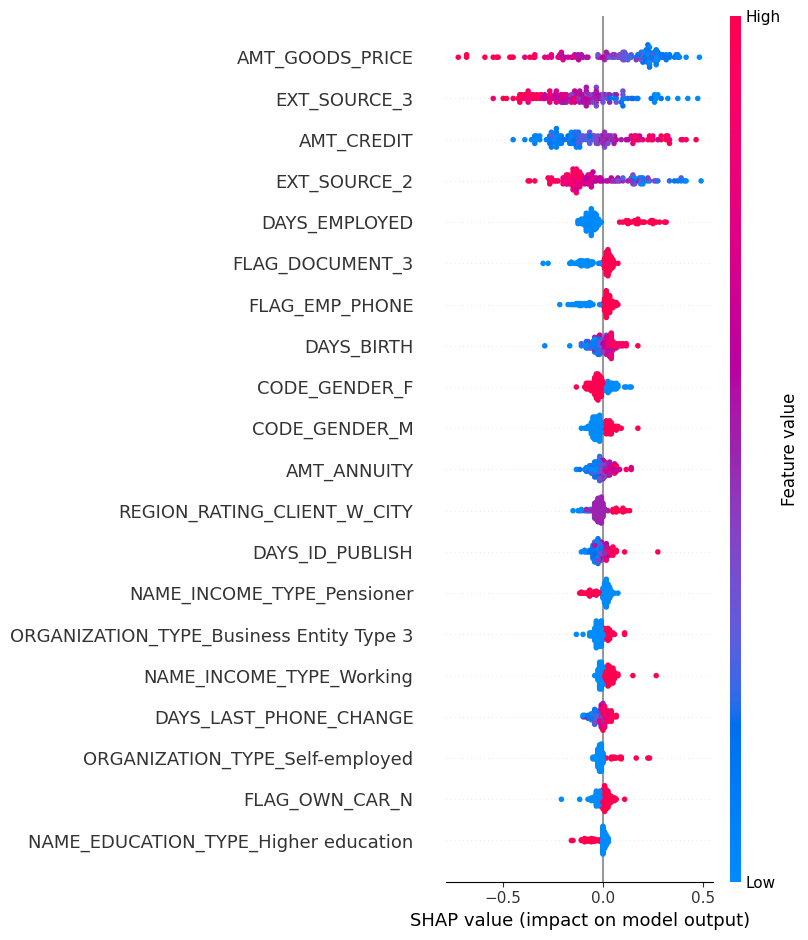

AttributeError: 'NoneType' object has no attribute 'values'

In [ ]:

# vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(np.abs(shap_values).mean(0), vals)),
                               columns=['col_name', 'feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                            ascending=False, inplace=True)
shap_importance.head()


Version sans rfe

import model
nettoyage dataset


In [23]:
def nettoyage(df):
    for col_na in df.isna().sum()[df.isna().sum() > 0].index:
        if df[col_na].dtype == 'object':
            # var categ val mqte => mot le plus fréquent
            df[col_na] = df[col_na].fillna(df[col_na].mode().values[0])
        else:
            df[col_na] = df[col_na].fillna(
                df[col_na].median())  # val mqtes => mediane
    return df.isna().sum().sum()


In [79]:
df_shap= echantillon_0.copy()
nettoyage(df_shap)
df_shap.isna().sum().sum()

0

In [80]:
#transfomer les  variables en catg + scaler 
df_shap = pipeline['categ_scaler'].transform(df_shap)
cols = [re.sub('one-hot-encoder__|remainder__', '', col_names)
        for col_names in pipeline.steps[0][1].get_feature_names_out()]  # colonnes récupérées avec one hot encoder
cols[:3], len(cols)

(['NAME_CONTRACT_TYPE_Cash loans',
  'NAME_CONTRACT_TYPE_Revolving loans',
  'CODE_GENDER_F'],
 164)

In [81]:
df_shap = pd.DataFrame(data = df_shap,columns = cols) #sous format de dataframe
df_shap.head()

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_N,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_Family,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,-0.090925,-0.023618,-0.022196,-0.018036,-0.070505,-0.058948,-0.156873,-0.268657,-0.285612,-0.440256
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.090925,-0.023618,-0.022196,-0.018036,-0.070505,-0.058948,-0.156873,-0.268657,-0.285612,-1.006779
2,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,-0.090925,-0.023618,-0.022196,-0.018036,-0.070505,-0.058948,-0.156873,-0.268657,-0.285612,-1.006779
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,-0.090925,-0.023618,-0.022196,-0.018036,-0.070505,-0.058948,-0.156873,-0.268657,-0.285612,-0.440256
4,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,-0.090925,-0.023618,-0.022196,-0.018036,-0.070505,-0.058948,-0.156873,-0.268657,-0.285612,-1.006779


 Réutilisation du X_test normalement 

In [75]:
df_shap_pred = df_shap.sample(10, random_state= 42) #sélection 10 id a prédire 
columns_selected = pipeline.steps[1][1].get_support() # a changer avec nouvel endroit dans pipeline
columns_selected=df_shap.columns[columns_selected] # a changer avec nouvel endroit dans pipeline
explainer = shap.Explainer(model,df_shap.drop(df_shap_pred.index.values,axis = 0)[columns_selected],seed = 42) #X_test a la place
shap_values_2 = explainer.shap_values(df_shap_pred[columns_selected])
shap_values_2


array([[ 0.00086051,  0.00086051,  0.05748131, ..., -0.0030232 ,
        -0.00928758,  0.00457076],
       [ 0.00086051,  0.00086051, -0.02582493, ..., -0.0030232 ,
        -0.00928758,  0.00457076],
       [ 0.00086051,  0.00086051, -0.02582493, ..., -0.0030232 ,
        -0.00928758,  0.00457076],
       ...,
       [ 0.00086051,  0.00086051,  0.05748131, ..., -0.0030232 ,
         0.00379352,  0.00457076],
       [ 0.00086051,  0.00086051, -0.02582493, ..., -0.0030232 ,
        -0.00928758,  0.00457076],
       [ 0.00086051,  0.00086051, -0.02582493, ..., -0.0030232 ,
         0.00379352,  0.00457076]])

In [30]:
 val_to_return = {'prediction': [0],
                    'feature_importance':[1,2,3],
                    'nom_colonnes': ['test'],
                    'score': [0.1]}

In [33]:
from fastapi.encoders import jsonable_encoder

In [35]:
df_f = pd.read_csv('shap_glob_val_sup_0.csv')


In [69]:
0.04*100

4.0

In [75]:
data_graph = df_f[df_f['feature_importance']>0.001]

In [76]:

source_f = ColumnDataSource(dict(x=data_graph['feature_importance'].values,
                                 y=data_graph['nom_variables'].values))

f= figure(x_range=(min(data_graph['feature_importance'].values)-0.005,max(data_graph['feature_importance'].values)+0.05),
          y_range=(data_graph['nom_variables'].values),
          width=500,
          height=800)

f.hbar(y='y', right="x", left=0.5, height=0.4, source=source_f)
f.ygrid.grid_line_color = None
f.yaxis.axis_label_text_font_size = "1pt"
f.yaxis.major_label_text_font_size = "5pt"
f.xaxis.axis_label = "feature importance globale"
f.outline_line_color = None
show(f)

In [ ]:
test_col['x_values'].value_counts().to_dict()['A']


1

In [ ]:
np.argwhere('x_values'==test_col.columns.values).ravel()[0]

0

In [84]:
x

NameError: name 'x' is not defined

In [140]:
val_sorted = val_sorted[np.where(val_sorted != 0, True, False)]

array([8.46483030e-20, 3.41932504e-19, 1.40148170e-18, 2.78896232e-04,
       2.83311468e-04, 3.34154879e-04, 3.47598527e-04, 3.50306082e-04,
       3.65241251e-04, 3.92521346e-04, 4.10272412e-04, 5.40896691e-04,
       6.68859080e-04, 7.97767094e-04, 8.12907242e-04, 8.60508616e-04,
       8.60508616e-04, 1.04041802e-03, 1.34694494e-03, 1.36358849e-03,
       1.42796586e-03, 1.55358557e-03, 1.75382427e-03, 1.91493458e-03,
       1.92595157e-03, 1.95815328e-03, 2.05741370e-03, 2.09505043e-03,
       2.19765238e-03, 2.22522538e-03, 2.34201419e-03, 2.47537819e-03,
       2.68590052e-03, 3.02320280e-03, 3.18765203e-03, 3.28320340e-03,
       3.44099857e-03, 3.82181716e-03, 3.99676806e-03, 4.00008009e-03,
       4.05511105e-03, 4.29824483e-03, 4.32574475e-03, 4.32887884e-03,
       4.48948204e-03, 5.27831471e-03, 5.36172354e-03, 5.38303798e-03,
       5.42451983e-03, 5.99114605e-03, 6.16377364e-03, 7.02320819e-03,
       7.17113255e-03, 7.39503489e-03, 7.63117839e-03, 7.99277343e-03,
      

NameError: name 'shap_values' is not defined

In [46]:
# feature importance globale shap_value pour plusieurs prédictions a faire avec x Test
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, CDSView, BooleanFilter
from bokeh.plotting import figure

TOOLTIPS = [
    ("index", "$index"),
    ("Importance de la variable", "@x"),  # v3
    ("Nom de la variable", "@y")]

mean_ = np.abs(shap_values_2).mean(0) #moyenne des features importance chaque variable
val_sorted = mean_[np.where(np.sort(mean_) != 0, True, False)] #filtre des variables triées par ordre croissant et différents de 0
idx_val_sorted = np.argsort(mean_)[np.where(np.sort(mean_) != 0, True, False)] #filtre des index des variables triées par ordre croissant et différents de 0

data = dict(x=np.sort(mean_[sup_0]),
            y=[columns_selected[index_col] for index_col in idx_val_sorted]) # a changer avec toutes les colonnes

source = ColumnDataSource(data)
p = figure(y_range=source.data['y'],
           x_range=((min(source.data['x'])-0.005)
                    ,(max(source.data['x'])+0.05)),
           width=600, height=750, toolbar_location=None,
           title="Importance des variables pour les prédictions",
           tooltips=TOOLTIPS)

p.hbar(y='y', right="x", left=0, height=0.4, source=source)

p.ygrid.grid_line_color = None
p.xaxis.axis_label = "feature_importance par variable"
p.yaxis.major_label_text_font_size = "6pt"
p.outline_line_color = None
show(p)

NameError: name 'shap_values_2' is not defined

In [15]:
import numpy as np
import pandas as pd

In [21]:
test_val = val_f[abs(pd.Series([0.0, 0.0, 0.005, -0.01, 0.0, -0.055, 
0.03, 0.005, -0.01, 0.0, -0.005, 0.0, 0.0, 0.0, 0.0, 0.0, -0.03, -0.005, 0.0, -0.005, 0.0, 0.0, 0.0, 0.0, -0.005, 0.01, 0.0, 0.0, 0.0, -0.015, -0.015, 0.0, -0.005, 0.0, 0.0, 0.0, 0.0, 
0.0, 0.0, 0.0, 0.0, 0.0, 0.005, 0.0, -0.005, 0.0, 0.0, -0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
0.0, 0.0, 0.0, 0.0, 0.0, -0.015, -0.005, -0.01, -0.005, 0.0, -0.045, 0.0, 0.025, 0.0, -0.005, -0.005, 0.0, 0.0, 0.0, -0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.005, -0.005, 0.0, 0.0, 0.0, 0.0, 0.0, -0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01, -0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.07, -0.005, 0.01, 0.015, -0.005, 0.0, -0.075, -0.025, -0.005, 0.0, 0.0, 0.0, 0.0, 0.005, 0.035, 0.0, 0.0, 0.025, -0.04, 0.0, 0.0, 0.0, -0.005, 0.0, 0.0, -0.015, -0.015, -0.085, 0.0, 0.0, -0.03, 0.0, 0.01, 0.0, -0.01, -0.01, 0.0, -0.005, -0.015, 0.0, 
0.005, -0.015, 0.005, -0.015, 0.01, 0.005, -0.05, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, -0.005, -0.02, 0.0, -0.005, 0.0, 0.0, -0.03, 0.0, 0.005, 0.0, -0.01, 0.005, 0.025, 0.0, 0.0, 0.0, -0.005, 0.0, 0.015, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.005, 0.0, -0.02, -0.015, -0.03]))>0.0001]

In [25]:
test_val.index


IndexError: index 77 is out of bounds for axis 0 with size 77

In [17]:
abs(val_f) >0.0001

0      False
1      False
2       True
3       True
4      False
       ...  
240     True
241    False
242     True
243     True
244     True
Length: 245, dtype: bool

In [ ]:
import feature_importance

In [158]:
explainer

Simulation export explainer

In [160]:
pseudo = open("pseudo_explainer.pkl","wb")
pickle.dump(explainer, pseudo)
pseudo.close()

Import de l'explainer

In [162]:
pseudo = open("pseudo_explainer.pkl","rb")
pseudo = pickle.load(pseudo)

Import pipeline model

In [164]:
pipeline_model = open("pipeline_transfo_model.pkl", "rb")
pipeline_model = pickle.load(pipeline_model)

In [168]:
pseudo(pipeline_model['categ_scaler'].transform()) # a priori fonctionne, difference dans la shape attendu par explainer

ValueError: operands could not be broadcast together with shapes (1,245) (131,) 

In [6]:
test_col = pd.DataFrame(data)

In [27]:
test_col['x_values'].value_counts().to_dict()['A']


1

In [81]:
import json
import requests
from bokeh.models import Range1d

NameError: name 'source_fl' is not defined

In [91]:
test_json = {'prediction': 1, 'feature_importance': [-0.01, 0.0, -0.04, 0.07, 0.0, -0.07,
                                                     0.03, -0.105, 0.0, -0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.02, 0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -
                                                     0.01, 0.0, 0.0, -0.005, 0.0, 0.0, -0.005, -
                                                     0.005, -0.005, 0.005, 0.0, 0.015, 0.0,
                                                     0.0, 0.0, -0.005, 0.0, 0.0, -0.005, 0.0, 0.0, 0.0, 0.0, -0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.005, -0.025, 0.005, -0.005, -0.005, 0.0, 0.0, -0.005, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, -0.01, 0.03, 0.06, 0.1, -0.005, 0.015, 0.09, 0.02, 0.02, 0.01, 0.0, 0.0, -0.03, 0.0, -0.005, 0.0, -0.01, 0.0, 0.0, -0.04, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, -0.06, -0.03, 0.19, 0.005, 0.005, 0.0, 0.01, -0.01, 0.0, 0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.005, 0.015, -0.005, 0.0, 0.005, 0.005, -0.005, 0.0, -0.01, 0.0, -0.005, 0.0, 0.005, 0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.015, -0.01, 0.0, 0.01, 0.0, 0.015, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015, 0.03, -0.02], 'nom_colonnes': ['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_F', 'CODE_GENDER_M', 'CODE_GENDER_XNA', 'FLAG_OWN_CAR_N', 'FLAG_OWN_CAR_Y', 'FLAG_OWN_REALTY_Y', 'FLAG_OWN_REALTY_N', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Group of people', 'NAME_INCOME_TYPE_Working', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Widow', 'NAME_FAMILY_STATUS_Unknown', 'NAME_HOUSING_TYPE_House / apartment', 'NAME_HOUSING_TYPE_With parents', 'NAME_HOUSING_TYPE_Municipal apartment', 'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_Office apartment', 'NAME_HOUSING_TYPE_Co-op apartment', 'OCCUPATION_TYPE_Laborers', 'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Core staff', 'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_High skill tech staff', 'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Medicine staff', 'OCCUPATION_TYPE_Security staff', 'OCCUPATION_TYPE_Cooking staff', 'OCCUPATION_TYPE_Cleaning staff', 'OCCUPATION_TYPE_Private service staff', 'OCCUPATION_TYPE_Low-skill Laborers', 'OCCUPATION_TYPE_Waiters/barmen staff', 'OCCUPATION_TYPE_Secretaries', 'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_HR staff', 'OCCUPATION_TYPE_IT staff', 'WEEKDAY_APPR_PROCESS_START_TUESDAY', 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'WEEKDAY_APPR_PROCESS_START_MONDAY', 'WEEKDAY_APPR_PROCESS_START_FRIDAY', 'WEEKDAY_APPR_PROCESS_START_SATURDAY', 'WEEKDAY_APPR_PROCESS_START_SUNDAY', 'ORGANIZATION_TYPE_Business Entity Type 3', 'ORGANIZATION_TYPE_XNA', 'ORGANIZATION_TYPE_Self-employed', 'ORGANIZATION_TYPE_Other', 'ORGANIZATION_TYPE_Medicine', 'ORGANIZATION_TYPE_Business Entity Type 2', 'ORGANIZATION_TYPE_Government', 'ORGANIZATION_TYPE_School', 'ORGANIZATION_TYPE_Trade: type 7', 'ORGANIZATION_TYPE_Kindergarten', 'ORGANIZATION_TYPE_Construction', 'ORGANIZATION_TYPE_Business Entity Type 1', 'ORGANIZATION_TYPE_Transport: type 4', 'ORGANIZATION_TYPE_Trade: type 3', 'ORGANIZATION_TYPE_Industry: type 9', 'ORGANIZATION_TYPE_Industry: type 3', 'ORGANIZATION_TYPE_Security', 'ORGANIZATION_TYPE_Housing', 'ORGANIZATION_TYPE_Industry: type 11', 'ORGANIZATION_TYPE_Military', 'ORGANIZATION_TYPE_Bank', 'ORGANIZATION_TYPE_Agriculture', 'ORGANIZATION_TYPE_Police', 'ORGANIZATION_TYPE_Transport: type 2', 'ORGANIZATION_TYPE_Postal', 'ORGANIZATION_TYPE_Security Ministries', 'ORGANIZATION_TYPE_Trade: type 2', 'ORGANIZATION_TYPE_Restaurant', 'ORGANIZATION_TYPE_Services', 'ORGANIZATION_TYPE_University', 'ORGANIZATION_TYPE_Industry: type 7', 'ORGANIZATION_TYPE_Transport: type 3', 'ORGANIZATION_TYPE_Industry: type 1', 'ORGANIZATION_TYPE_Hotel', 'ORGANIZATION_TYPE_Electricity', 'ORGANIZATION_TYPE_Industry: type 4', 'ORGANIZATION_TYPE_Trade: type 6',
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      'ORGANIZATION_TYPE_Industry: type 5', 'ORGANIZATION_TYPE_Insurance', 'ORGANIZATION_TYPE_Telecom', 'ORGANIZATION_TYPE_Emergency', 'ORGANIZATION_TYPE_Industry: type 2', 'ORGANIZATION_TYPE_Advertising', 'ORGANIZATION_TYPE_Culture', 'ORGANIZATION_TYPE_Realtor', 'ORGANIZATION_TYPE_Industry: type 12', 'ORGANIZATION_TYPE_Trade: type 1', 'ORGANIZATION_TYPE_Mobile', 'ORGANIZATION_TYPE_Legal Services', 'ORGANIZATION_TYPE_Cleaning', 'ORGANIZATION_TYPE_Transport: type 1', 'ORGANIZATION_TYPE_Industry: type 6', 'ORGANIZATION_TYPE_Industry: type 10', 'ORGANIZATION_TYPE_Religion', 'ORGANIZATION_TYPE_Industry: type 13', 'ORGANIZATION_TYPE_Trade: type 4', 'ORGANIZATION_TYPE_Trade: type 5', 'ORGANIZATION_TYPE_Industry: type 8', 'FONDKAPREMONT_MODE_reg oper account', 'FONDKAPREMONT_MODE_reg oper spec account', 'FONDKAPREMONT_MODE_not specified', 'FONDKAPREMONT_MODE_org spec account', 'HOUSETYPE_MODE_block of flats', 'HOUSETYPE_MODE_specific housing', 'HOUSETYPE_MODE_terraced house', 'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Wooden', 'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others', 'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes', 'SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'], 'score': 0.6683938558483298}


In [92]:
test_json['prediction']

1

In [90]:
fl= figure(x_range=(0,1),y_range=([]),width=400, height=400)
source_fl = ColumnDataSource(dict(x=[0], y=[0]))  # a changer
fl.hbar(y='y', right="x", left=0, height=0.4, source=source_fl)

fl.ygrid.grid_line_color = None
fl.yaxis.axis_label_text_font_size = "1pt"
fl.yaxis.major_label_text_font_size = "5pt"
fl.xaxis.axis_label = "feature importance locale"

df_retrieved = [0,0]
url =  "http://127.0.0.1:8000"
res = requests.post(url+"/predict/"+str(101099))
print('contenu apres envoi ', res._content)
df_retrieved[1] = json.loads(res._content.decode('utf-8'))  # data_retrieved
new_data = dict() 
#new_data['feature_importance'] = df_retrieved[1]['feature_importance']
# sinon ne chnage qu'une information à la fois 0 index de la ligne
new_data['x'] = df_retrieved[1]['feature_importance']
new_data['y'] = df_retrieved[1]['nom_colonnes']
source_fl.data = new_data
fl.y_range.factors = df_retrieved[1]['nom_colonnes']
range_x=Range1d(min(df_retrieved[1]['feature_importance']),max(df_retrieved[1]['feature_importance']))
fl.x_range = range_x
show(fl)

contenu apres envoi  b'{"prediction":0,"feature_importance":[0.0,0.0,0.0,-0.03,0.0,0.01,-0.015,0.0,-0.005,-0.005,0.0,-0.005,0.0,0.0,0.0,0.0,0.0,-0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.005,-0.005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.005,0.0,-0.005,-0.005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.015,-0.005,0.005,-0.005,-0.005,-0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.005,-0.005,-0.04,-0.025,0.045,0.02,0.01,0.0,-0.02,-0.015,0.005,0.0,0.0,-0.005,0.0,-0.005,0.0,-0.005,-0.01,0.0,-0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.005,-0.025,0.0,0.0,-0.005,0.0,-0.005,0.0,-0.025,0.005,0.0,0.0,0.0,0.0,0.0,0.0,-0.01,0.01,0.0,-0.005,0.0,0.0,0.005,0.0,0.0,0.005,0.0,-0.005,0.0,-0.015,-0.04,0.0,0.0,-0.0

In [10]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show


# define the categorical data
categories = ['A', 'B', 'C', 'D', 'E']

# define the data for the vbar chart
data = {'x_values': categories, 'y_values': [3, 4, 1, 2, 5]}

# create a ColumnDataSource object from the data
source = ColumnDataSource(data)

# create a figure object
p = figure(x_range=categories)

# add the vbar chart
p.vbar(x='x_values', top='y_values', source=source, width=0.9)

# add a point to the chart
dot=p.circle(x=['B'], y=[4], size=20, color='red')
#p.renderers.remove(dot)
dot = p.circle(x=[],y=[],name='dot')

# show the chart
show(p)
